In [1]:
from io import BytesIO

import polars as pl
from PIL import Image

from deep_statutes.config import STATUTES_DATA_DIR

In [2]:
parquet_path = STATUTES_DATA_DIR / "co/pdfs.parquet"

In [3]:
# Load as LazyFrame (doesn't load data into memory until needed)
lf = pl.scan_parquet(parquet_path)

# Show the schema without reading any data
print("LazyFrame schema:")
print(lf.collect_schema())

# Select only specific columns
pdf_paths_df = lf.select(['pdf_path']).collect()
pdf_paths_df

LazyFrame schema:
Schema({'uuid': String, 'pdf_path': String, 'pdf_bytes': Binary, 'page_text': List(String), 'page_image': List(Binary)})


pdf_path
str
"""/Users/eric/Development/deep_s…"
"""/Users/eric/Development/deep_s…"
"""/Users/eric/Development/deep_s…"
"""/Users/eric/Development/deep_s…"
"""/Users/eric/Development/deep_s…"
…
"""/Users/eric/Development/deep_s…"
"""/Users/eric/Development/deep_s…"
"""/Users/eric/Development/deep_s…"


In [ ]:
result_df = lf.head(1).select(
    pl.col("page_image").list.get(0)  # Gets the first binary from the List(Binary)
).collect()
png_bytes = result_df.item()
image = Image.open(BytesIO(png_bytes))
image

In [4]:
search_phrase = "Interdepartmental Cooperation"

lf_with_page_numbers = lf.with_columns(
    pl.col("page_text")
    .list.eval(pl.element().str.contains(search_phrase, literal=True).arg_true())
    #.list.eval(pl.element() + 1)
    .alias("found_on_pages")
)

# lf_with_page_numbers.collect()
lf_with_page_numbers.collect_schema()

Schema([('uuid', String),
        ('pdf_path', String),
        ('pdf_bytes', Binary),
        ('page_text', List(String)),
        ('page_image', List(Binary)),
        ('found_on_pages', List(UInt32))])

In [5]:
lf_filtered_for_non_empty = lf_with_page_numbers.filter(
    pl.col("found_on_pages").list.len() > 0
)
df_filtered = lf_filtered_for_non_empty.collect()
# print all rows
print("\nRows where the phrase was found, with page numbers:")
with pl.Config(fmt_str_lengths=150):
    print(df_filtered[['pdf_path', 'found_on_pages']])


Rows where the phrase was found, with page numbers:
shape: (1, 2)
┌────────────────────────────────────────────────────────────────────────┬────────────────┐
│ pdf_path                                                               ┆ found_on_pages │
│ ---                                                                    ┆ ---            │
│ str                                                                    ┆ list[u32]      │
╞════════════════════════════════════════════════════════════════════════╪════════════════╡
│ /Users/eric/Development/deep_statutes_data/co/pdf/crs2024-title-17.pdf ┆ [226]          │
└────────────────────────────────────────────────────────────────────────┴────────────────┘


In [15]:
selected_images_expr = pl.col("page_image").list.gather(
    pl.col("found_on_pages").list.eval(pl.element())
)

lf_with_selected_images = lf_filtered_for_non_empty.with_columns(
    selected_page_images = selected_images_expr
)


columns_to_collect = ["uuid", "pdf_path", "found_on_pages", "selected_page_images"]

# Use .select() to specify the subset of columns, then .collect()
subset_df = lf_with_selected_images.select(columns_to_collect).collect()

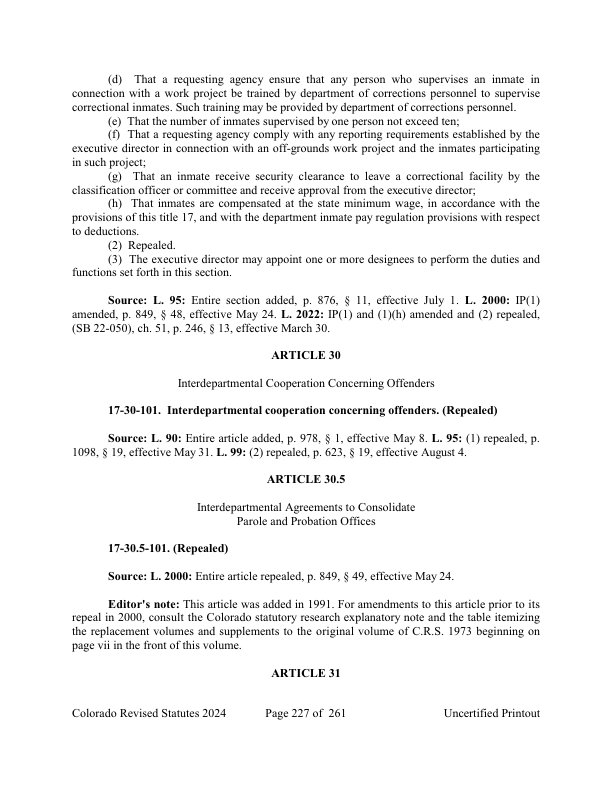

In [16]:
png_bytes = subset_df['selected_page_images'][0][0]
image = Image.open(BytesIO(png_bytes))
image